### 자전거 대여량(수요량) 파악을 위한 가설 수립 
#### 가설1: 자전거 대여량(수요량)은 월별/시간별로 차이가 있을 것이다.   
#### 가설2: 자전거 대여량(수요량)은 전년 동월 대비 증가하였을 것이다.
---

* 필요한 라이브러리 호출

In [12]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

* DB 연결

In [3]:
conn = psycopg2.connect(host='localhost', dbname='bike_sharing', user='postgres', password='DIRAHR528', port='5432')

In [4]:
cur = conn.cursor()  # DB로 연결하기 

* 쿼리문으로 확인

In [5]:
cur.execute("SELECT * FROM bike_sharing limit 5;")  # SQL문 작성 
conn.commit()
print(cur.fetchall())

[(1, datetime.datetime(2011, 1, 1, 0, 0), 1, 0, 0, 1, 9.84, 14.395, 81.0, 0.0, 3, 13, 16), (2, datetime.datetime(2011, 1, 1, 1, 0), 1, 0, 0, 1, 9.02, 13.635, 80.0, 0.0, 8, 32, 40), (3, datetime.datetime(2011, 1, 1, 2, 0), 1, 0, 0, 1, 9.02, 13.635, 80.0, 0.0, 5, 27, 32), (4, datetime.datetime(2011, 1, 1, 3, 0), 1, 0, 0, 1, 9.84, 14.395, 75.0, 0.0, 3, 10, 13), (5, datetime.datetime(2011, 1, 1, 4, 0), 1, 0, 0, 1, 9.84, 14.395, 75.0, 0.0, 0, 1, 1)]


In [50]:
cur.execute("SELECT COUNT(*) AS row_count FROM bike_sharing;")  # SQL문 작성 
conn.commit()
print(cur.fetchone())

(10886,)


In [6]:
# pandas를 이용해서 dataframe으로 보기 
pd.read_sql("SELECT * FROM bike_sharing limit 5;", conn)

,id,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspread,casual,registered,count
0,1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


계절, 공휴일 유무, 일하는 날 유무, 날씨, 습도 등의 변수로 구성된 데이터    
계절(season)은 1,2,3,4 순서대로 봄, 여름, 가을, 겨울인데 유럽의 경우 한국과 사계절 기간이 동일함에도 불구하고 계절별이 아니라 분기별로 기록된 것으로 보인다.

In [7]:
pd.read_sql("SELECT * FROM bike_sharing ORDER BY datetime DESC limit 5;", conn)

,id,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspread,casual,registered,count
0,10886,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66.0,8.9981,4,84,88
1,10885,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61.0,6.0032,12,117,129
2,10884,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61.0,15.0013,4,164,168
3,10883,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57.0,15.0013,10,231,241
4,10882,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50.0,26.0027,7,329,336


* 가설 1(자전거 수요량은 월별, 요일별, 시간별로 차이가 있을 것이다.) 검증

In [49]:
query = '''
        SELECT datetime
        , CAST(EXTRACT(hour from datetime) AS VARCHAR) AS hour
        , CAST(EXTRACT(month from datetime) AS VARCHAR) AS month
        , CAST(EXTRACT(DOW from datetime) AS VARCHAR) AS week
        , season
        , SUM(count) AS count
        , SUM(casual) AS casual
        , SUM(registered) AS registered
        
        FROM bike_sharing
        GROUP BY datetime, season
        ORDER BY datetime;
        '''

daily_count = pd.read_sql(query, conn)  # 모든 일자가 19일까지 있음.
daily_count

,datetime,hour,month,week,season,count,casual,registered
0,2011-01-01 00:00:00,0,1,6,1,16,3,13
1,2011-01-01 01:00:00,1,1,6,1,40,8,32
2,2011-01-01 02:00:00,2,1,6,1,32,5,27
3,2011-01-01 03:00:00,3,1,6,1,13,3,10
4,2011-01-01 04:00:00,4,1,6,1,1,0,1
...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,19,12,3,4,336,7,329
10882,2012-12-19 20:00:00,20,12,3,4,241,10,231
10883,2012-12-19 21:00:00,21,12,3,4,168,4,164
10884,2012-12-19 22:00:00,22,12,3,4,129,12,117


In [9]:
hourly_count = pd.DataFrame(daily_count[['hour','count','casual','registered']].groupby('hour').mean()).reset_index()
weekly_count = pd.DataFrame(daily_count[['week','count','casual','registered']].groupby('week').mean()).reset_index()
monthly_count = pd.DataFrame(daily_count[['month','count','casual','registered']].groupby('month').mean()).reset_index()
seasonly_count = pd.DataFrame(daily_count[['season','count','casual','registered']].groupby('season').mean()).reset_index()

hourly_count['hour'] = pd.to_numeric(hourly_count['hour'])
weekly_count['week'] = pd.to_numeric(weekly_count['week'])
monthly_count['month'] = pd.to_numeric(monthly_count['month'])

hourly_count = hourly_count.sort_values('hour')
weekly_count = weekly_count.sort_values('week')
monthly_count = monthly_count.sort_values('month')

weekly_count['week'].replace(0,'일',inplace= True)
weekly_count['week'].replace(1,'월',inplace= True)
weekly_count['week'].replace(2,'화',inplace= True)
weekly_count['week'].replace(3,'수',inplace= True)
weekly_count['week'].replace(4,'목',inplace= True)
weekly_count['week'].replace(5,'금',inplace= True)
weekly_count['week'].replace(6,'토',inplace= True)

seasonly_count['season'].replace(1,"겨울", inplace = True)
seasonly_count['season'].replace(1,"겨울", inplace = True)
seasonly_count['season'].replace(1,"겨울", inplace = True)
seasonly_count['season'].replace(1,"겨울", inplace = True)

Text(0.5, 1.0, '미등록 회원의 자전거 수요량 대비 월별 전체 자전거 수요량')

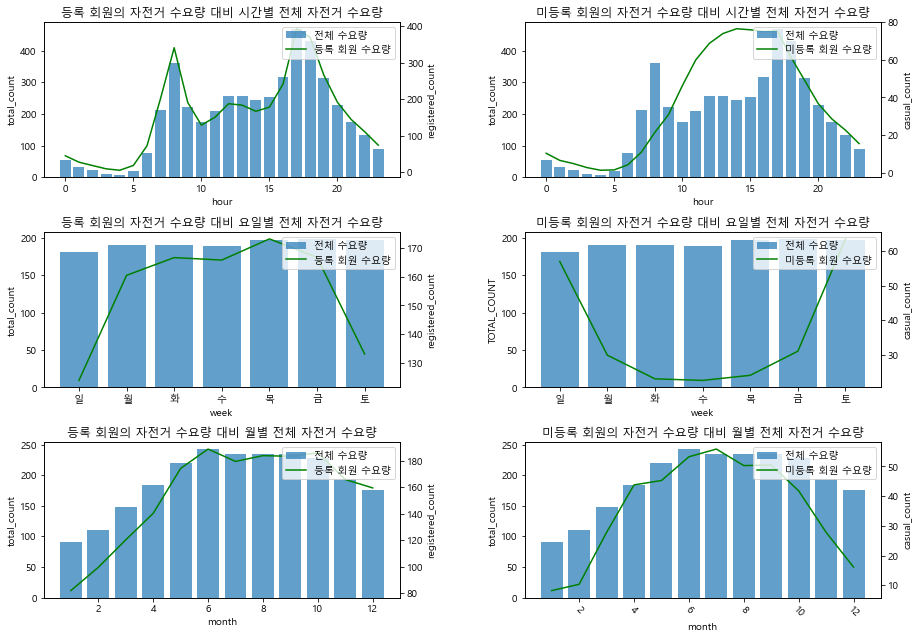

In [14]:
fig, ax1 = plt.subplots(3,2, figsize = (15,10))

# 시간별 
plt.xticks(rotation = -45)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

ax1[0][0].bar(hourly_count["hour"], hourly_count["count"], data = hourly_count, alpha = 0.7, label = '전체 수요량')
ax1[0][0].set_xlabel("hour")
ax1[0][0].set_ylabel("total_count")

ax2 = ax1[0][0].twinx()
ax2.plot(hourly_count.hour, hourly_count.registered, "green",label="등록 회원 수요량")
ax2.set_ylabel("registered_count")

lines_1, labels_1 = ax1[0][0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc='upper right')

plt.title('등록 회원의 자전거 수요량 대비 시간별 전체 자전거 수요량')

ax1[0][1].bar(hourly_count["hour"], hourly_count["count"], data = hourly_count, alpha = 0.7, label = '전체 수요량')
ax1[0][1].set_xlabel("hour")
ax1[0][1].set_ylabel("total_count")

ax2 = ax1[0][1].twinx()
ax2.plot(hourly_count.hour, hourly_count.casual, "green",label = '미등록 회원 수요량')
ax2.set_ylabel("casual_count")


lines_1, labels_1 = ax1[0][1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc='upper right')

plt.title('미등록 회원의 자전거 수요량 대비 시간별 전체 자전거 수요량')

# 요일별 
ax1[1][0].bar(weekly_count["week"], weekly_count["count"], data = weekly_count, alpha = 0.7, label = '전체 수요량')
ax1[1][0].set_xlabel("week")
ax1[1][0].set_ylabel("total_count")

ax2 = ax1[1][0].twinx()
ax2.plot(weekly_count.week, weekly_count.registered, "green",label = '등록 회원 수요량')
ax2.set_ylabel("registered_count")

lines_1, labels_1 = ax1[1][0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc='upper right')

plt.title('등록 회원의 자전거 수요량 대비 요일별 전체 자전거 수요량')

ax1[1][1].bar(weekly_count["week"], weekly_count["count"], data = weekly_count, alpha = 0.7, label = '전체 수요량')
ax1[1][1].set_xlabel("week")
ax1[1][1].set_ylabel("TOTAL_COUNT")

ax2 = ax1[1][1].twinx()
ax2.plot(weekly_count.week, weekly_count.casual, "green",label = '미등록 회원 수요량')
ax2.set_ylabel("casual_count")

lines_1, labels_1 = ax1[1][1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc='upper right')

plt.title('미등록 회원의 자전거 수요량 대비 요일별 전체 자전거 수요량')

# 월별
ax1[2][0].bar(monthly_count["month"], monthly_count["count"], data = monthly_count, alpha = 0.7, label = '전체 수요량')
ax1[2][0].set_xlabel("month")
ax1[2][0].set_ylabel("total_count")

ax2 = ax1[2][0].twinx()
ax2.plot(monthly_count.month, monthly_count.registered, "green", label = '등록 회원 수요량')
ax2.set_ylabel("registered_count")


lines_1, labels_1 = ax1[2][0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc='upper right')

plt.title('등록 회원의 자전거 수요량 대비 월별 전체 자전거 수요량')

ax1[2][1].bar(monthly_count["month"], monthly_count["count"], data = monthly_count, alpha = 0.7, label = '전체 수요량')
ax1[2][1].set_xlabel("month")
ax1[2][1].set_ylabel("total_count")

ax2 = ax1[2][1].twinx()
ax2.plot(monthly_count.month, monthly_count.casual, "green", label = "미등록 회원 수요량")
ax2.set_ylabel("casual_count")


lines_1, labels_1 = ax1[2][1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc='upper right')

plt.title('미등록 회원의 자전거 수요량 대비 월별 전체 자전거 수요량')


In [15]:
hourly_count['registered_percent'] = hourly_count['registered']/sum(hourly_count['registered'])*100
hourly_count['casual_percent'] = hourly_count['casual']/sum(hourly_count['casual'])*100

In [16]:
hourly_count.sort_values(['count'], ascending = False).head()

,hour,count,casual,registered,registered_percent,casual_percent
9,17,468.765351,75.440789,393.324561,10.581318,8.765573
10,18,430.859649,61.396930,369.462719,9.939381,7.133797
22,8,362.769231,21.542857,341.226374,9.179759,2.503095
8,16,316.372807,75.083333,241.289474,6.491231,8.724040
11,19,315.278509,49.074561,266.203947,7.161487,5.702043


In [17]:
hourly_count.sort_values(['registered'], ascending = False).head()

,hour,count,casual,registered,registered_percent,casual_percent
9,17,468.765351,75.440789,393.324561,10.581318,8.765573
10,18,430.859649,61.396930,369.462719,9.939381,7.133797
22,8,362.769231,21.542857,341.226374,9.179759,2.503095
11,19,315.278509,49.074561,266.203947,7.161487,5.702043
8,16,316.372807,75.083333,241.289474,6.491231,8.724040


In [18]:
hourly_count.sort_values(['casual'], ascending = False).head()

,hour,count,casual,registered,registered_percent,casual_percent
6,14,243.442982,76.589912,166.853070,4.488724,8.899091
7,15,254.298246,76.028509,178.269737,4.795858,8.833861
9,17,468.765351,75.440789,393.324561,10.581318,8.765573
8,16,316.372807,75.083333,241.289474,6.491231,8.724040
5,13,257.787281,74.059211,183.728070,4.942700,8.605046


시간별 자전거 수요량은 17-18시에 가장 많고 그 다음으로 8시, 16시, 19시 순으로 많음.   
등록된 사용자의 자전거 수요량은 전체 수요량과 동일한 시간대에 많고 미등록된 사용자의 대여한 양은 주로 오후 시간대(13-17시)임.   

In [19]:
weekly_count['registered_percent'] = weekly_count['registered']/sum(weekly_count['registered'])*100
weekly_count['casual_percent'] = weekly_count['casual']/sum(weekly_count['casual'])*100

In [20]:
weekly_count.sort_values(['count'], ascending = False)

,week,count,casual,registered,registered_percent,casual_percent
5,금,197.844343,31.001962,166.842381,15.304654,12.349897
4,목,197.296201,24.007083,173.289118,15.896021,9.563427
6,토,196.665404,63.625000,133.040404,12.203957,25.345564
1,월,190.390716,29.843972,160.546744,14.727147,11.888602
2,화,189.723847,22.979207,166.744639,15.295688,9.153964
3,수,188.411348,22.521599,165.889749,15.217267,8.971672
0,일,180.839772,57.051298,123.788474,11.355267,22.726874


In [21]:
weekly_count.sort_values(['registered_percent'], ascending = False)

,week,count,casual,registered,registered_percent,casual_percent
4,목,197.296201,24.007083,173.289118,15.896021,9.563427
5,금,197.844343,31.001962,166.842381,15.304654,12.349897
2,화,189.723847,22.979207,166.744639,15.295688,9.153964
3,수,188.411348,22.521599,165.889749,15.217267,8.971672
1,월,190.390716,29.843972,160.546744,14.727147,11.888602
6,토,196.665404,63.625000,133.040404,12.203957,25.345564
0,일,180.839772,57.051298,123.788474,11.355267,22.726874


In [22]:
weekly_count.sort_values(['casual_percent'], ascending = False)

,week,count,casual,registered,registered_percent,casual_percent
6,토,196.665404,63.625000,133.040404,12.203957,25.345564
0,일,180.839772,57.051298,123.788474,11.355267,22.726874
5,금,197.844343,31.001962,166.842381,15.304654,12.349897
1,월,190.390716,29.843972,160.546744,14.727147,11.888602
4,목,197.296201,24.007083,173.289118,15.896021,9.563427
2,화,189.723847,22.979207,166.744639,15.295688,9.153964
3,수,188.411348,22.521599,165.889749,15.217267,8.971672


요일별 자전거 수요량은 대체로 비슷하지만 가장 적게 평균적으로 가장 적게 예약한 요일은 일요일 123.79건, 목요일 173.29건으로 약 50건 차이가 난다.
그 반면에 예약을 하지 않고 대여한 경우 토요일과 일요일이 가장 많고 가장 적게 예약한 수요일과 평균적으로 약 40건 차이가 나는 것으로 보아 주말에 계획없이 자전거를 대여하는 경우가 많은 것으로 보인다.

In [23]:
monthly_count['registered_percent'] = monthly_count['registered']/sum(monthly_count['registered'])*100
monthly_count['casual_percent'] = monthly_count['casual']/sum(monthly_count['casual'])*100

In [24]:
monthly_count.sort_values(['count'], ascending = False)

,month,count,casual,registered,registered_percent,casual_percent
8,6,242.031798,53.260965,188.770833,10.130666,12.355501
9,7,235.325658,55.862939,179.462719,9.631132,12.959108
10,8,234.118421,50.296053,183.822368,9.865099,11.667699
11,9,233.805281,50.496150,183.309131,9.837556,11.714118
1,10,227.699232,41.807903,185.891328,9.976133,9.698615
7,5,219.459430,45.268640,174.190789,9.348206,10.501438
2,11,193.677278,27.829857,165.847420,8.900447,6.455982
6,4,184.160616,43.798680,140.361936,7.532731,10.160436
3,12,175.614035,16.118421,159.495614,8.559568,3.739158
5,3,148.169811,27.809101,120.360710,6.459336,6.451167


In [25]:
monthly_count.sort_values(['casual'], ascending = False)

,month,count,casual,registered,registered_percent,casual_percent
9,7,235.325658,55.862939,179.462719,9.631132,12.959108
8,6,242.031798,53.260965,188.770833,10.130666,12.355501
11,9,233.805281,50.496150,183.309131,9.837556,11.714118
10,8,234.118421,50.296053,183.822368,9.865099,11.667699
7,5,219.459430,45.268640,174.190789,9.348206,10.501438
6,4,184.160616,43.798680,140.361936,7.532731,10.160436
1,10,227.699232,41.807903,185.891328,9.976133,9.698615
2,11,193.677278,27.829857,165.847420,8.900447,6.455982
5,3,148.169811,27.809101,120.360710,6.459336,6.451167
3,12,175.614035,16.118421,159.495614,8.559568,3.739158


In [26]:
monthly_count.sort_values(['registered'], ascending = False)

,month,count,casual,registered,registered_percent,casual_percent
8,6,242.031798,53.260965,188.770833,10.130666,12.355501
1,10,227.699232,41.807903,185.891328,9.976133,9.698615
10,8,234.118421,50.296053,183.822368,9.865099,11.667699
11,9,233.805281,50.496150,183.309131,9.837556,11.714118
9,7,235.325658,55.862939,179.462719,9.631132,12.959108
7,5,219.459430,45.268640,174.190789,9.348206,10.501438
2,11,193.677278,27.829857,165.847420,8.900447,6.455982
3,12,175.614035,16.118421,159.495614,8.559568,3.739158
6,4,184.160616,43.798680,140.361936,7.532731,10.160436
5,3,148.169811,27.809101,120.360710,6.459336,6.451167


월별 평균 자전거 대여량이 가장 많은 경우는 6,7,8월 달인 여름이다. 9, 10월 가을까지도 많이 대여하는 것으로 보이고 겨울과 약 152건 차이가 난다.

In [27]:
cur.execute('''SELECT CORR(registered, count) AS Registered_CORR
            , CORR(casual, count) AS casual_corr 
            FROM bike_sharing;''')

print(cur.fetchall())

[(0.970948105809828, 0.690413565328674)]


In [28]:
query = '''
        SELECT datetime
        , concat(EXTRACT(year from datetime), '-',EXTRACT(month from datetime)) AS year_month
        , SUM(count) AS total_count
        , SUM(SUM(count)) OVER(PARTITION BY concat(EXTRACT(year from datetime), '-',EXTRACT(month from datetime)) ORDER BY datetime ROWS UNBOUNDED PRECEDING) AS agg_count
        FROM bike_sharing
        GROUP BY datetime
        ORDER BY datetime
        ;'''

In [29]:
monthly_count = pd.read_sql(query,conn)

In [30]:
monthly_count

,datetime,year_month,total_count,agg_count
0,2011-01-01 00:00:00,2011-1,16,16.0
1,2011-01-01 01:00:00,2011-1,40,56.0
2,2011-01-01 02:00:00,2011-1,32,88.0
3,2011-01-01 03:00:00,2011-1,13,101.0
4,2011-01-01 04:00:00,2011-1,1,102.0
...,...,...,...,...
10881,2012-12-19 19:00:00,2012-12,336,98351.0
10882,2012-12-19 20:00:00,2012-12,241,98592.0
10883,2012-12-19 21:00:00,2012-12,168,98760.0
10884,2012-12-19 22:00:00,2012-12,129,98889.0


In [31]:
query = '''WITH daily_count AS(
            SELECT datetime
            , EXTRACT(year from datetime) AS year
            , EXTRACT(month from datetime) AS month
            , EXTRACT(day from datetime) AS date
            , SUM(count) AS count
            , SUM(casual) AS casual
            , SUM(registered) AS registered
            FROM bike_sharing
            GROUP BY datetime),
            
            daily_count_total AS(
            SELECT CAST(concat(year,'-',month,'-',date) AS date) AS date
                , CAST(year AS integer)
                , CAST(month AS integer)
                , SUM(count) AS daily_total_count
                , SUM(casual) AS daily_total_casual_count
                , SUM(registered) AS daily_total_registered_count
                
            FROM daily_count
            GROUP BY concat(year,'-',month,'-',date), year, month
            ORDER BY date)
            
            SELECT month
                , SUM(CASE year WHEN 2011 THEN daily_total_count END) AS count_2011
                , SUM(CASE year WHEN 2012 THEN daily_total_count END) AS count_2012
                , 100.0*SUM(CASE year WHEN 2012 THEN daily_total_count END)
                /SUM(CASE year WHEN 2011 THEN daily_total_count END)AS count_rate
                
                , SUM(CASE year WHEN 2011 THEN daily_total_casual_count END) AS casual_count_2011
                , SUM(CASE year WHEN 2012 THEN daily_total_casual_count END) AS casual_count_2012
                , 100.0*SUM(CASE year WHEN 2012 THEN daily_total_casual_count END)
                /SUM(CASE year WHEN 2011 THEN daily_total_casual_count END)AS casual_rate
            
                , SUM(CASE year WHEN 2011 THEN daily_total_registered_count END) AS registered_count_2011
                , SUM(CASE year WHEN 2012 THEN daily_total_registered_count END) AS registered_count_2012
                , 100.0*SUM(CASE year WHEN 2012 THEN daily_total_registered_count END)
                /SUM(CASE year WHEN 2011 THEN daily_total_registered_count END)AS registered_rate
            
            FROM daily_count_total
            GROUP BY month
            ORDER BY month;
            
            '''

result = pd.read_sql(query, conn)
result

,month,count_2011,count_2012,count_rate,casual_count_2011,casual_count_2012,casual_rate,registered_count_2011,registered_count_2012,registered_rate
0,1,23552.0,56332.0,239.181386,2008.0,5244.0,261.155378,21544.0,51088.0,237.133309
1,2,32844.0,66269.0,201.768968,3776.0,5521.0,146.212924,29068.0,60748.0,208.985826
2,3,38735.0,94766.0,244.652123,7910.0,17146.0,216.763590,30825.0,77620.0,251.808597
3,4,50517.0,116885.0,231.377556,12229.0,27584.0,225.562188,38288.0,89301.0,233.234956
4,5,79713.0,120434.0,151.084516,15865.0,25420.0,160.226915,63848.0,95014.0,148.812805
5,6,89776.0,130957.0,145.870834,19600.0,28974.0,147.826531,70176.0,101983.0,145.324612
6,7,92848.0,121769.0,131.148759,26145.0,24802.0,94.863263,66703.0,96967.0,145.371273
7,8,83296.0,130220.0,156.334038,17580.0,28290.0,160.921502,65716.0,101930.0,155.106823
8,9,79104.0,133425.0,168.670358,18311.0,27590.0,150.674458,60793.0,105835.0,174.090767
9,10,79522.0,127912.0,160.851085,17159.0,20928.0,121.965149,62363.0,106984.0,171.550439


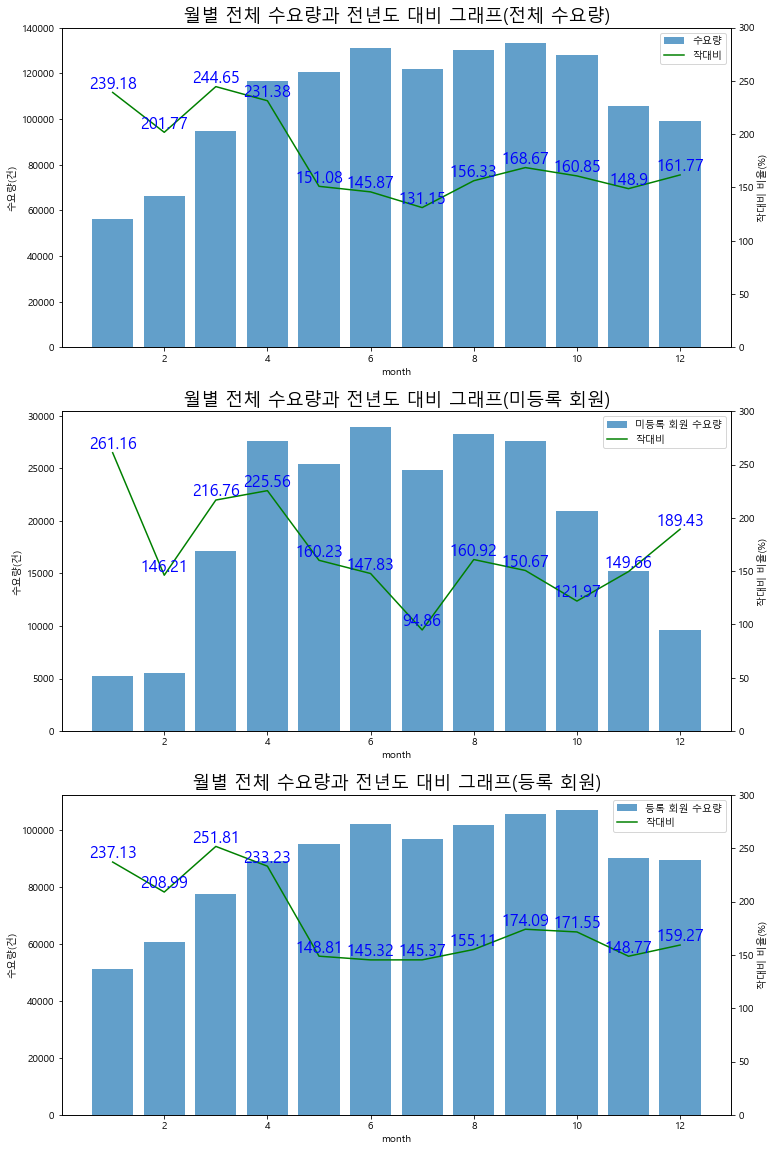

In [45]:
fig, ax1 = plt.subplots(3,1, figsize = (12,20))

# total_count
ax_bar = ax1[0].bar(result.month, result.count_2012,alpha = 0.7,label = '수요량')
ax1[0].set_xlabel("month")
ax1[0].set_ylabel("수요량(건)")
ax2 = ax1[0].twinx()
ax_plot = ax2.plot(result.month, result.count_rate,'green',label = '작대비')
ax2.set_ylabel("작대비 비율(%)")

lines_1, labels_1 = ax1[0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc=0)

plt.ylim([0,300])

plt.title("월별 전체 수요량과 전년도 대비 그래프(전체 수요량)", fontsize = 18)

for i, v in enumerate(result.month):
    plt.text(v, round(result.count_rate[i],2), round(result.count_rate[i],2),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 16, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')

# casual_count
ax_bar = ax1[1].bar(result.month, result.casual_count_2012,alpha = 0.7,label = '미등록 회원 수요량')
ax1[1].set_xlabel("month")
ax1[1].set_ylabel("수요량(건)")

ax2 = ax1[1].twinx()
ax_plot = ax2.plot(result.month, result.casual_rate,'green',label = '작대비')
ax2.set_ylabel("작대비 비율(%)")

lines_1, labels_1 = ax1[1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc=0)

plt.ylim([0,300])

plt.title("월별 전체 수요량과 전년도 대비 그래프(미등록 회원)", fontsize = 18)

for i, v in enumerate(result.month):
    plt.text(v, round(result.casual_rate[i],2), round(result.casual_rate[i],2),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 16, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')

# registered count
ax_bar = ax1[2].bar(result.month, result.registered_count_2012,alpha = 0.7,label = '등록 회원 수요량')
ax2 = ax1[2].twinx()

ax1[2].set_xlabel("month")
ax1[2].set_ylabel("수요량(건)")

ax_plot = ax2.plot(result.month, result.registered_rate,'green',label = '작대비')
ax2.set_ylabel("작대비 비율(%)")

lines_1, labels_1 = ax1[2].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax2.legend(lines, labels, loc=0)

plt.ylim([0,300])

plt.title("월별 전체 수요량과 전년도 대비 그래프(등록 회원)", fontsize = 18)

for i, v in enumerate(result.month):
    plt.text(v, round(result.registered_rate[i],2), round(result.registered_rate[i],2),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 16, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')
    
    
plt.show()